In [ ]:
# Stratified Sampling

In [1]:
import sys
import os
from pathlib import Path
import importlib
sys.path.append('..')

import pandas as pd

import data.dataframe_preparation as preparation
from data.custom_widgets import ReportsLabeler
import data
importlib.reload(data.custom_widgets)
importlib.reload(data.dataframe_preparation)

############### CONFIG ###############
FIRM_METADATA = os.path.abspath("../input_files/Firm_Metadata.csv")
DATA_INPUT_PATH = os.path.abspath("../input_files/annual_reports/")
MASTER_DATA_PATH = os.path.abspath("../input_files/annual_reports/Firm_AnnualReport_DF.csv")
LABEL_OUTPUT_FN = 'Firm_AnnualReport_Labels_DF.pkl'

HOLD_OUT_YEAR = 2019
HOLD_OUT_COMPANY = 'gb_unilever_plc'

SEED = 99
OVERRIDE_FILE = False
######################################

# Create master output file if not exits
master_file = Path(MASTER_DATA_PATH)
if not master_file.is_file() or OVERRIDE_FILE:
    df = preparation.get_df(input_path=DATA_INPUT_PATH, report_type_mappings={"20F": "AR"}, selected_report_types={"AR"}, include_text=False, include_page_no=False, include_toc=False)
    df = df.set_index("id")
    # Add additional labelling columns
    df['should_label'] = False
    df['is_labelled'] = False
    
    # Load the meta data
    df_meta = pd.read_csv(FIRM_METADATA)
    df_meta = df_meta.set_index('id')
    df['company_id'] = df['country'] + "_" + df['company']
    df = df.drop(columns=['country'])
    df = df.merge(df_meta, left_on='company_id', right_index=True)
    
    # TODO: Raise/Alert or remove if all outputs are there!
    df = df[df['output_file'].notna()]
    
    # Select all reports from year and company
    df_to_label = df[(df.year == HOLD_OUT_YEAR) | (df.company_id == HOLD_OUT_COMPANY)].copy()
    df_to_label['should_label'] = True
    nr_held_out_reports = len(df_to_label)
    df.update(df_to_label)
    
    # Remaining reports: Take sample with stratification along variables. n = amount of reports in each year AND industry...
    df_to_label = df[df.should_label == False]
    # Note: Do not use apply here, as otherwise the random state is equal for each group, possibly leading to non-random sampling!
    df_to_label = df_to_label.groupby(['year', 'icb_industry']).sample(n=1, random_state=SEED)

    df_to_label['should_label'] = True
    df.update(df_to_label)
    # Shuffle the dataset
    df = df.reset_index()
    df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    df.to_csv(MASTER_DATA_PATH)
    df

,id,company,orig_report_type,report_type,year,input_file,output_file,should_label,is_labelled,company_id,firm_name,ticker,country,icb_industry,icb_supersector
0,gb_glencore_plc-AR_2017,glencore_plc,AR,AR,2017.0,gb_glencore_plc/AR_2017.pdf,AR_2017.yml,True,False,gb_glencore_plc,GLENCORE,NaN,gb,55 Basic Materials,5510 Basic Resources
1,gb_glaxosmithkline-AR_2004,glaxosmithkline,AR,AR,2004.0,gb_glaxosmithkline/AR_2004.pdf,AR_2004.yml,True,False,gb_glaxosmithkline,GLAXOSMITHKLINE,NaN,gb,20 Health Care,2010 Health Care
2,gb_rio_tinto-AR_2011,rio_tinto,AR,AR,2011.0,gb_rio_tinto/AR_2011.pdf,AR_2011.yml,True,False,gb_rio_tinto,RIO TINTO,NaN,gb,55 Basic Materials,5510 Basic Resources
3,dk_novo_nordisk_b-AR_2009,novo_nordisk_b,AR,AR,2009.0,dk_novo_nordisk_b/AR_2009.pdf,AR_2009.yml,False,False,dk_novo_nordisk_b,NOVO NORDISK B,NaN,dk,20 Health Care,2010 Health Care
4,es_bco_santander-AR_2019,bco_santander,AR,AR,2019.0,es_bco_santander/AR_2019.pdf,AR_2019.yml,True,False,es_bco_santander,BCO SANTANDER,NaN,es,30 Financials,3010 Banks
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787,es_bco_bilbao_vizcaya_argentaria-AR_2013,bco_bilbao_vizcaya_argentaria,AR,AR,2013.0,es_bco_bilbao_vizcaya_argentaria/AR_2013.pdf,AR_2013.yml,True,False,es_bco_bilbao_vizcaya_argentaria,BCO BILBAO VIZCAYA ARGENTARIA,NaN,es,30 Financials,3010 Banks
788,fr_lvmh_moet_hennessy-AR_2014,lvmh_moet_hennessy,AR,AR,2014.0,fr_lvmh_moet_hennessy/AR_2014.pdf,AR_2014.yml,False,False,fr_lvmh_moet_hennessy,LVMH MOET HENNESSY,NaN,fr,40 Consumer Discretionary,4020 Consumer Products and Services
789,ch_ubs_group-AR_2010,ubs_group,AR,AR,2010.0,ch_ubs_group/AR_2010.pdf,AR_2010.yml,False,False,ch_ubs_group,UBS GROUP,NaN,ch,30 Financials,3010 Banks
790,es_telefonica-AR_1999,telefonica,AR,AR,1999.0,es_telefonica/AR_1999.pdf,AR_1999.yml,True,False,es_telefonica,TELEFONICA,NaN,es,15 Telecommunications,1510 Telecommunications


In [3]:
len(df_to_label)

185

In [133]:
df_to_label.groupby(['icb_industry']).count()

,company,orig_report_type,report_type,year,input_file,output_file,should_label,is_labelled,company_id,firm_name,ticker,country,icb_supersector
icb_industry,,,,,,,,,,,,,
10 Technology,20,20,20,20,20,20,20,20,20,20,0,20,20
15 Telecommunications,20,20,20,20,20,20,20,20,20,20,0,20,20
20 Health Care,20,20,20,20,20,20,20,20,20,20,0,20,20
30 Financials,20,20,20,20,20,20,20,20,20,20,0,20,20
40 Consumer Discretionary,20,20,20,20,20,20,20,20,20,20,0,20,20
45 Consumer Staples,18,18,18,18,18,18,18,18,18,18,0,18,18
50 Industrials,20,20,20,20,20,20,20,20,20,20,0,20,20
55 Basic Materials,16,16,16,16,16,16,16,16,16,16,0,16,16
60 Energy,16,16,16,16,16,16,16,16,16,16,0,16,16


In [134]:
df_to_label.groupby(['year']).count()

,company,orig_report_type,report_type,input_file,output_file,should_label,is_labelled,company_id,firm_name,ticker,country,icb_industry,icb_supersector
year,,,,,,,,,,,,,
1999.0,6,6,6,6,6,6,6,6,6,0,6,6,6
2000.0,6,6,6,6,6,6,6,6,6,0,6,6,6
2001.0,7,7,7,7,7,7,7,7,7,0,7,7,7
2002.0,7,7,7,7,7,7,7,7,7,0,7,7,7
2003.0,9,9,9,9,9,9,9,9,9,0,9,9,9
2004.0,10,10,10,10,10,10,10,10,10,0,10,10,10
2005.0,10,10,10,10,10,10,10,10,10,0,10,10,10
2006.0,10,10,10,10,10,10,10,10,10,0,10,10,10
2007.0,10,10,10,10,10,10,10,10,10,0,10,10,10


In [37]:
df_to_label = df[(df.year != HOLD_OUT_YEAR) & (df.company_id != HOLD_OUT_COMPANY)].copy()
df_to_label = df_to_label[df_to_label.should_label]

df_to_label = df_to_label.groupby('icb_industry').sample(10, random_state=SEED)
df_to_label.to_csv('/Users/david/Desktop/Firm_AnnualReport_100.csv')
#test.groupby('year').count()
# sampledf = df_to_label.sample(100, weights = df_to_label.groupby(['year', 'icb_industry']).transform('count'))
# sampledf.groupby('year').count()

In [4]:
import pandas as pd
df_to_label = pd.read_csv('/Users/david/Desktop/Firm_AnnualReport_100.csv')

In [9]:
df_to_label.groupby('year').count()

,Unnamed: 0,id,company,orig_report_type,report_type,input_file,output_file,should_label,is_labelled,company_id,firm_name,ticker,country,icb_industry,icb_supersector
year,,,,,,,,,,,,,,,
1999.0,4,4,4,4,4,4,4,4,4,4,4,0,4,4,4
2000.0,3,3,3,3,3,3,3,3,3,3,3,0,3,3,3
2001.0,6,6,6,6,6,6,6,6,6,6,6,0,6,6,6
2002.0,4,4,4,4,4,4,4,4,4,4,4,0,4,4,4
2003.0,3,3,3,3,3,3,3,3,3,3,3,0,3,3,3
2004.0,3,3,3,3,3,3,3,3,3,3,3,0,3,3,3
2005.0,3,3,3,3,3,3,3,3,3,3,3,0,3,3,3
2006.0,6,6,6,6,6,6,6,6,6,6,6,0,6,6,6
2007.0,4,4,4,4,4,4,4,4,4,4,4,0,4,4,4


<AxesSubplot:>

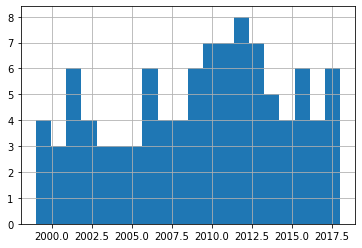

In [12]:
df_to_label['year'].hist(bins=20)